In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define data preprocessing parameters
batch_size = 64
sequence_length = 3
image_size = (150, 150)
num_classes = 3
input_shape = (sequence_length, 150, 150, 3)

# Define data directories
data_dir = "C:/physics99"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
validation_dir = os.path.join(data_dir, 'validation')

# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Custom data generator to create sequences of images
def create_sequence_generator(generator, sequence_length):
    while True:
        x_batch, y_batch = next(generator)
        if len(x_batch) < sequence_length:
            print(f"Skipping batch with insufficient data: {len(x_batch)} images")
            continue  # Skip this batch if not enough images for a sequence
        x_seq, y_seq = [], []
        for i in range(len(x_batch) - sequence_length + 1):
            x_seq.append(x_batch[i:i + sequence_length])
            y_seq.append(y_batch[i + sequence_length - 1])
        if len(x_seq) == 0:
            print(f"Generated empty sequence. Batch size: {len(x_batch)}")
            continue
        yield np.array(x_seq), np.array(y_seq)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size * sequence_length,  # Adjust batch size
    class_mode='categorical'
)

valid_data = test_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size * sequence_length,  # Adjust batch size
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size * sequence_length,  # Adjust batch size
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix
)

train_seq_gen = create_sequence_generator(train_data, sequence_length)
valid_seq_gen = create_sequence_generator(valid_data, sequence_length)
test_seq_gen = create_sequence_generator(test_data, sequence_length)

# Define the RNN model
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape),
    TimeDistributed(MaxPooling2D(2, 2)),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D(2, 2)),
    TimeDistributed(Conv2D(128, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D(2, 2)),
    TimeDistributed(Flatten()),
    LSTM(512),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Calculate steps per epoch
steps_per_epoch_train = train_data.samples // (batch_size * sequence_length)
steps_per_epoch_valid = valid_data.samples // (batch_size * sequence_length)

# Train the model
history = model.fit(
    train_seq_gen,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=valid_seq_gen,
    validation_steps=steps_per_epoch_valid,
    epochs=100
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_seq_gen, steps=test_data.samples // (batch_size * sequence_length))
print('Test loss:', test_loss)
print(f'Test accuracy: {test_acc}')

# Generate predictions for the test data
test_data.reset()
predictions = model.predict(test_seq_gen, steps=test_data.samples // (batch_size * sequence_length))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.concatenate([np.argmax(test_data[i][1], axis=1) for i in range(len(test_data))])[:len(predicted_classes)]

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Found 959 images belonging to 3 classes.
Found 120 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 3, 148, 148,    │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 74, 74, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 72, 72, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 36, 36, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 3, 34, 34, 128) │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 3, 17, 17, 128) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 3, 36992)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 512)            │    76,810,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,167,683 (294.37 MB)

 Trainable params: 77,167,683 (294.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 5:11 311s/step - accuracy: 0.3389 - loss: 1.3958 

ResourceExhaustedError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
MemoryError: Unable to allocate 147. MiB for an array with shape (190, 3, 150, 150, 3) and data type float32
Traceback (most recent call last):

  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\generator_data_adapter.py", line 52, in get_tf_iterator
    for batch in self.generator:

  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_9528\3253680940.py", line 53, in create_sequence_generator
    yield np.array(x_seq), np.array(y_seq)
          ^^^^^^^^^^^^^^^

numpy.core._exceptions._ArrayMemoryError: Unable to allocate 147. MiB for an array with shape (190, 3, 150, 150, 3) and data type float32


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_4263]

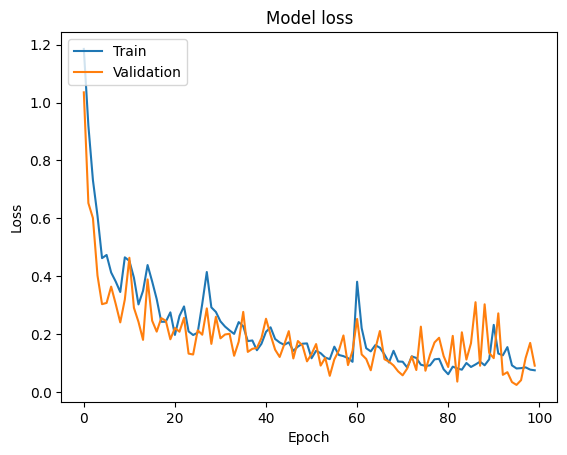

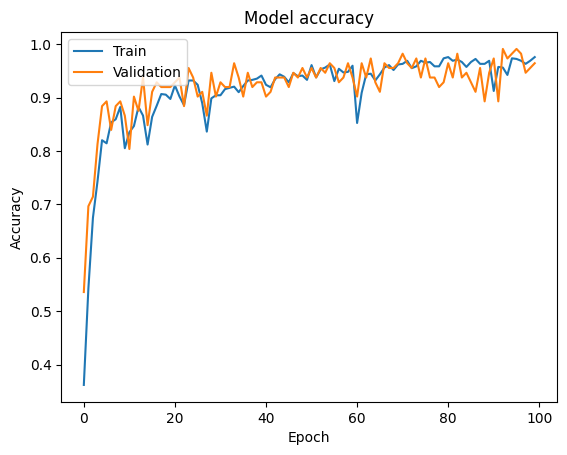

In [5]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot training history for loss
plot_loss(history)

# Plot training history for accuracy
plot_accuracy(history)
